In [6]:
import os
import sys
import json
import argparse
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [7]:
from matplotlib import pyplot as plt

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)
        
        return x_cont, x_other, label

In [9]:
class BayesianCNN(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32):
        super(BayesianCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(dyn_channels, 10, kernel_size=4, padding=1) # 9
        self.bn1 = nn.BatchNorm1d(10)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=4, padding=1) # 8
        self.bn2 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(20, 30, kernel_size=4, padding=1) # 7
        self.bn3 = nn.BatchNorm1d(30)
        self.conv4 = nn.Conv1d(30, 30, kernel_size=2, padding=1) # 6
        #self.bn4 = nn.BatchNorm1d(25)
        #nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.conv4.weight, nonlinearity='relu')
        self.fc1 = nn.Linear(30*8, 30)
        self.fc2 = nn.Linear(30, 10)
        self.flatten = nn.Flatten()
        self.fc_static1 = nn.Linear(stat_channels, 25)
        self.fc_static2 = nn.Linear(25, 30)
        self.fc_static3 = nn.Linear(30, 10)
        self.softmax = nn.Softmax(-1)
        #self.bn5 = nn.BatchNorm1d(20)
        self.fc_final1 = nn.Linear(20, 10)
        #self.bn6 = nn.BatchNorm1d(10)
        self.fc_final2 = nn.Linear(10,2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        #nn.init.xavier_normal_(self.fc1.weight)
        #nn.init.xavier_normal_(self.fc2.weight)
        #nn.init.xavier_normal_(self.fc_static1.weight)
        #nn.init.xavier_normal_(self.fc_static2.weight)
        #nn.init.xavier_normal_(self.fc_static3.weight)
        #nn.init.xavier_normal_(self.fc_final1.weight)
        #nn.init.xavier_normal_(self.fc_final2.weight)

    def forward(self, x_dynamic, x_static):
        
        x_dynamic = x_dynamic.permute(0,2,1)
        #print(f"the shape of x_dynamic after permutation is {x_dynamic.shape}")
        x = self.bn1(self.conv1(x_dynamic))
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = self.bn3(self.conv3(x))
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.flatten(x) 

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        y = torch.relu(self.fc_static1(x_static))
        y = torch.relu(self.fc_static2(y))
        y = torch.relu(self.fc_static3(y))

        z = torch.cat((x, y), dim=1)
        z = self.fc_final2((torch.relu(self.fc_final1(z))))
        return z
    def model(self, x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights
        conv1w_prior = dist.Normal(loc=torch.zeros_like(self.conv1.weight), scale=15*torch.ones_like(self.conv1.weight)).to_event(3)
        conv1b_prior = dist.Normal(loc=torch.zeros_like(self.conv1.bias), scale=15*torch.ones_like(self.conv1.bias)).to_event(1)
        conv2w_prior = dist.Normal(loc=torch.zeros_like(self.conv2.weight), scale=15*torch.ones_like(self.conv2.weight)).to_event(3)
        conv2b_prior = dist.Normal(loc=torch.zeros_like(self.conv2.bias), scale=15*torch.ones_like(self.conv2.bias)).to_event(1)
        conv3w_prior = dist.Normal(loc=torch.zeros_like(self.conv3.weight), scale=15*torch.ones_like(self.conv3.weight)).to_event(3)
        conv3b_prior = dist.Normal(loc=torch.zeros_like(self.conv3.bias), scale=15*torch.ones_like(self.conv3.bias)).to_event(1)
        conv4w_prior = dist.Normal(loc=torch.zeros_like(self.conv4.weight), scale=15*torch.ones_like(self.conv4.weight)).to_event(3)
        conv4b_prior = dist.Normal(loc=torch.zeros_like(self.conv4.bias), scale=15*torch.ones_like(self.conv4.bias)).to_event(1)
        fc1w_prior = dist.Normal(loc=torch.zeros_like(self.fc1.weight), scale=15*torch.ones_like(self.fc1.weight)).to_event(2)
        fc1b_prior = dist.Normal(loc=torch.zeros_like(self.fc1.bias), scale=15*torch.ones_like(self.fc1.bias)).to_event(1)
        fc2w_prior = dist.Normal(loc=torch.zeros_like(self.fc2.weight), scale=15*torch.ones_like(self.fc2.weight)).to_event(2)
        fc2b_prior = dist.Normal(loc=torch.zeros_like(self.fc2.bias), scale=15*torch.ones_like(self.fc2.bias)).to_event(1)
        fc_static1w_prior = dist.Normal(loc=torch.zeros_like(self.fc_static1.weight), scale=15*torch.ones_like(self.fc_static1.weight)).to_event(2)
        fc_static1b_prior = dist.Normal(loc=torch.zeros_like(self.fc_static1.bias), scale=15*torch.ones_like(self.fc_static1.bias)).to_event(1)
        fc_static2w_prior = dist.Normal(loc=torch.zeros_like(self.fc_static2.weight), scale=15*torch.ones_like(self.fc_static2.weight)).to_event(2)
        fc_static2b_prior = dist.Normal(loc=torch.zeros_like(self.fc_static2.bias), scale=15*torch.ones_like(self.fc_static2.bias)).to_event(1)
        fc_static3w_prior = dist.Normal(loc=torch.zeros_like(self.fc_static3.weight), scale=15*torch.ones_like(self.fc_static3.weight)).to_event(2)
        fc_static3b_prior = dist.Normal(loc=torch.zeros_like(self.fc_static3.bias), scale=15*torch.ones_like(self.fc_static3.bias)).to_event(1)
        fc_final1w_prior = dist.Normal(loc=torch.zeros_like(self.fc_final1.weight), scale=15*torch.ones_like(self.fc_final1.weight)).to_event(2)
        fc_final1b_prior = dist.Normal(loc=torch.zeros_like(self.fc_final1.bias), scale=15*torch.ones_like(self.fc_final1.bias)).to_event(1)
        fc_final2w_prior = dist.Normal(loc=torch.zeros_like(self.fc_final2.weight), scale=15*torch.ones_like(self.fc_final2.weight)).to_event(2)
        fc_final2b_prior = dist.Normal(loc=torch.zeros_like(self.fc_final2.bias), scale=15*torch.ones_like(self.fc_final2.bias)).to_event(1)
        bn1w_prior = dist.Normal(loc=torch.zeros_like(self.bn1.weight), scale=10*torch.ones_like(self.bn1.weight)).to_event(1)
        bn1b_prior = dist.Normal(loc=torch.zeros_like(self.bn1.bias), scale=10*torch.ones_like(self.bn1.bias)).to_event(1)
        bn2w_prior = dist.Normal(loc=torch.zeros_like(self.bn2.weight), scale=10*torch.ones_like(self.bn2.weight)).to_event(1)
        bn2b_prior = dist.Normal(loc=torch.zeros_like(self.bn2.bias), scale=10*torch.ones_like(self.bn2.bias)).to_event(1)
        bn3w_prior = dist.Normal(loc=torch.zeros_like(self.bn3.weight), scale=10*torch.ones_like(self.bn3.weight)).to_event(1)
        bn3b_prior = dist.Normal(loc=torch.zeros_like(self.bn3.bias), scale=10*torch.ones_like(self.bn3.bias)).to_event(1)

        model_priors = {
            'conv1.weight': conv1w_prior, 'conv1.bias': conv1b_prior,
            'conv2.weight': conv2w_prior, 'conv2.bias': conv2b_prior,
            'conv3.weight': conv3w_prior, 'conv3.bias': conv3b_prior,
            'conv4.weight': conv4w_prior, 'conv3.bias': conv4b_prior,
            #'conv4.weight': dist.Normal(0, 1).expand([25, 30, 4]).to_event(3),
            'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
            'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
            'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,
            'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior,
            'fc_static3.weight': fc_static3w_prior, 'fc_static3.bias': fc_static3b_prior,
            'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,
            'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior,
            'bn1.weight': bn1w_prior, 'bn1.bias': bn1b_prior,
            'bn2.weight': bn2w_prior, 'bn2.bias': bn2b_prior,
            'bn3.weight': bn3w_prior, 'bn3.bias': bn3b_prior
        }
        lifted_module = pyro.random_module("module", self, model_priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()
        #with pyro.plate("data", x_dynamic.size(0)):
        lhat = self.softmax(lifted_reg_model(x_dynamic, x_static))
        if y is not None:
                y = y.float()  
        pyro.sample("obs", dist.Categorical(logits=lhat).to_event(1), obs=y)
        '''
        # Condition on the observed data
        with pyro.plate("data", x_dynamic.size(0)):
            #prediction = lifted_reg_model(x_dynamic, x_static)
            #pyro.sample("obs", dist.Bernoulli(prediction).to_event(1), obs=y)
            #pyro.sample("obs", dist.Categorical(probs=prediction), obs=y)
            logits = lifted_reg_model(x_dynamic, x_static)  # This should output raw logits
            prediction = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
            if y is not None:
                    y = y.float()  
            pyro.sample("obs", dist.Bernoulli(prediction).to_event(1), obs=y)'''

    # Defining the guide function for variational inference
    def guide(self, x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        softplus = torch.nn.Softplus()
        conv1w_mu = torch.randn_like(self.conv1.weight)
        conv1w_sigma = torch.randn_like(self.conv1.weight)
        conv1w_mu_param = pyro.param("conv1w_mu", conv1w_mu)
        conv1w_sigma_param = softplus(pyro.param("conv1w_sigma", conv1w_sigma))
        conv1w_prior = dist.Normal(loc=conv1w_mu_param, scale=conv1w_sigma_param).to_event(3)
        conv1b_mu = torch.randn_like(self.conv1.bias)
        conv1b_sigma = torch.randn_like(self.conv1.bias)
        conv1b_mu_param = pyro.param("conv1b_mu", conv1b_mu)
        conv1b_sigma_param = softplus(pyro.param("conv1b_sigma", conv1b_sigma))
        conv1b_prior = dist.Normal(loc=conv1b_mu_param, scale=conv1b_sigma_param).to_event(1)

        conv2w_mu = torch.randn_like(self.conv2.weight)
        conv2w_sigma = torch.randn_like(self.conv2.weight)
        conv2w_mu_param = pyro.param("conv2w_mu", conv2w_mu)
        conv2w_sigma_param = softplus(pyro.param("conv2w_sigma", conv2w_sigma))
        conv2w_prior = dist.Normal(loc=conv2w_mu_param, scale=conv2w_sigma_param).to_event(3)
        conv2b_mu = torch.randn_like(self.conv2.bias)
        conv2b_sigma = torch.randn_like(self.conv2.bias)
        conv2b_mu_param = pyro.param("conv2b_mu", conv2b_mu)
        conv2b_sigma_param = softplus(pyro.param("conv2b_sigma", conv2b_sigma))
        conv2b_prior = dist.Normal(loc=conv2b_mu_param, scale=conv2b_sigma_param).to_event(1)

        conv3w_mu = torch.randn_like(self.conv3.weight)
        conv3w_sigma = torch.randn_like(self.conv3.weight)
        conv3w_mu_param = pyro.param("conv3w_mu", conv3w_mu)
        conv3w_sigma_param = softplus(pyro.param("conv3w_sigma", conv3w_sigma))
        conv3w_prior = dist.Normal(loc=conv3w_mu_param, scale=conv3w_sigma_param).to_event(3)
        conv3b_mu = torch.randn_like(self.conv3.bias)
        conv3b_sigma = torch.randn_like(self.conv3.bias)
        conv3b_mu_param = pyro.param("conv3b_mu", conv3b_mu)
        conv3b_sigma_param = softplus(pyro.param("conv3b_sigma", conv3b_sigma))
        conv3b_prior = dist.Normal(loc=conv3b_mu_param, scale=conv3b_sigma_param).to_event(1)

        conv4w_mu = torch.randn_like(self.conv4.weight)
        conv4w_sigma = torch.randn_like(self.conv4.weight)
        conv4w_mu_param = pyro.param("conv4w_mu", conv4w_mu)
        conv4w_sigma_param = softplus(pyro.param("conv4w_sigma", conv4w_sigma))
        conv4w_prior = dist.Normal(loc=conv4w_mu_param, scale=conv4w_sigma_param).to_event(3)
        conv4b_mu = torch.randn_like(self.conv4.bias)
        conv4b_sigma = torch.randn_like(self.conv4.bias)
        conv4b_mu_param = pyro.param("conv4b_mu", conv4b_mu)
        conv4b_sigma_param = softplus(pyro.param("conv4b_sigma", conv4b_sigma))
        conv4b_prior = dist.Normal(loc=conv4b_mu_param, scale=conv4b_sigma_param).to_event(1)

        fc1w_mu = torch.randn_like(self.fc1.weight)
        fc1w_sigma = torch.randn_like(self.fc1.weight)
        fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
        fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
        fc1w_prior = dist.Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).to_event(2)
        fc1b_mu = torch.randn_like(self.fc1.bias)
        fc1b_sigma = torch.randn_like(self.fc1.bias)
        fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
        fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
        fc1b_prior = dist.Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param).to_event(1)

        fc2w_mu = torch.randn_like(self.fc2.weight)
        fc2w_sigma = torch.randn_like(self.fc2.weight)
        fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
        fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
        fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).to_event(2)
        fc2b_mu = torch.randn_like(self.fc2.bias)
        fc2b_sigma = torch.randn_like(self.fc2.bias)
        fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
        fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
        fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param).to_event(1)

        fc_static1w_mu = torch.randn_like(self.fc_static1.weight)
        fc_static1w_sigma = torch.randn_like(self.fc_static1.weight)
        fc_static1w_mu_param = pyro.param("fc_static1w_mu", fc_static1w_mu)
        fc_static1w_sigma_param = softplus(pyro.param("fc_static1w_sigma", fc_static1w_sigma))
        fc_static1w_prior = dist.Normal(loc=fc_static1w_mu_param, scale=fc_static1w_sigma_param).to_event(2)
        fc_static1b_mu = torch.randn_like(self.fc_static1.bias)
        fc_static1b_sigma = torch.randn_like(self.fc_static1.bias)
        fc_static1b_mu_param = pyro.param("fc_static1b_mu", fc_static1b_mu)
        fc_static1b_sigma_param = softplus(pyro.param("fc_static1b_sigma", fc_static1b_sigma))
        fc_static1b_prior = dist.Normal(loc=fc_static1b_mu_param, scale=fc_static1b_sigma_param).to_event(1)

        fc_static2w_mu = torch.randn_like(self.fc_static2.weight)
        fc_static2w_sigma = torch.randn_like(self.fc_static2.weight)
        fc_static2w_mu_param = pyro.param("fc_static2w_mu", fc_static2w_mu)
        fc_static2w_sigma_param = softplus(pyro.param("fc_static2w_sigma", fc_static2w_sigma))
        fc_static2w_prior = dist.Normal(loc=fc_static2w_mu_param, scale=fc_static2w_sigma_param).to_event(2)
        fc_static2b_mu = torch.randn_like(self.fc_static2.bias)
        fc_static2b_sigma = torch.randn_like(self.fc_static2.bias)
        fc_static2b_mu_param = pyro.param("fc_static2b_mu", fc_static2b_mu)
        fc_static2b_sigma_param = softplus(pyro.param("fc_static2b_sigma", fc_static2b_sigma))
        fc_static2b_prior = dist.Normal(loc=fc_static2b_mu_param, scale=fc_static2b_sigma_param).to_event(1)

        fc_static3w_mu = torch.randn_like(self.fc_static3.weight)
        fc_static3w_sigma = torch.randn_like(self.fc_static3.weight)
        fc_static3w_mu_param = pyro.param("fc_static3w_mu", fc_static3w_mu)
        fc_static3w_sigma_param = softplus(pyro.param("fc_static3w_sigma", fc_static3w_sigma))
        fc_static3w_prior = dist.Normal(loc=fc_static3w_mu_param, scale=fc_static3w_sigma_param).to_event(2)
        fc_static3b_mu = torch.randn_like(self.fc_static3.bias)
        fc_static3b_sigma = torch.randn_like(self.fc_static3.bias)
        fc_static3b_mu_param = pyro.param("fc_static3b_mu", fc_static3b_mu)
        fc_static3b_sigma_param = softplus(pyro.param("fc_static3b_sigma", fc_static3b_sigma))
        fc_static3b_prior = dist.Normal(loc=fc_static3b_mu_param, scale=fc_static3b_sigma_param).to_event(1)

        fc_final1w_mu = torch.randn_like(self.fc_final1.weight)
        fc_final1w_sigma = torch.randn_like(self.fc_final1.weight)
        fc_final1w_mu_param = pyro.param("fc_final1w_mu", fc_final1w_mu)
        fc_final1w_sigma_param = softplus(pyro.param("fc_final1w_sigma", fc_final1w_sigma))
        fc_final1w_prior = dist.Normal(loc=fc_final1w_mu_param, scale=fc_final1w_sigma_param).to_event(2)
        fc_final1b_mu = torch.randn_like(self.fc_final1.bias)
        fc_final1b_sigma = torch.randn_like(self.fc_final1.bias)
        fc_final1b_mu_param = pyro.param("fc_final1b_mu", fc_final1b_mu)
        fc_final1b_sigma_param = softplus(pyro.param("fc_final1b_sigma", fc_final1b_sigma))
        fc_final1b_prior = dist.Normal(loc=fc_final1b_mu_param, scale=fc_final1b_sigma_param).to_event(1)

        fc_final2w_mu = torch.randn_like(self.fc_final2.weight)
        fc_final2w_sigma = torch.randn_like(self.fc_final2.weight)
        fc_final2w_mu_param = pyro.param("fc_final2w_mu", fc_final2w_mu)
        fc_final2w_sigma_param = softplus(pyro.param("fc_final2w_sigma", fc_final2w_sigma))
        fc_final2w_prior = dist.Normal(loc=fc_final2w_mu_param, scale=fc_final2w_sigma_param).to_event(2)
        fc_final2b_mu = torch.randn_like(self.fc_final2.bias)
        fc_final2b_sigma = torch.randn_like(self.fc_final2.bias)
        fc_final2b_mu_param = pyro.param("fc_final2b_mu", fc_final2b_mu)
        fc_final2b_sigma_param = softplus(pyro.param("fc_final2b_sigma", fc_final2b_sigma))
        fc_final2b_prior = dist.Normal(loc=fc_final2b_mu_param, scale=fc_final2b_sigma_param).to_event(1)

        bn1w_mu = torch.randn_like(self.bn1.weight)
        bn1w_sigma = torch.randn_like(self.bn1.weight)
        bn1w_mu_param = pyro.param("bn1w_mu", bn1w_mu)
        bn1w_sigma_param = softplus(pyro.param("bn1w_sigma", bn1w_sigma))
        bn1w_prior = dist.Normal(loc=bn1w_mu_param, scale=bn1w_sigma_param).to_event(1)
        bn1b_mu = torch.randn_like(self.bn1.bias)
        bn1b_sigma = torch.randn_like(self.bn1.bias)
        bn1b_mu_param = pyro.param("bn1b_mu", bn1b_mu)
        bn1b_sigma_param = softplus(pyro.param("bn1b_sigma", bn1b_sigma))
        bn1b_prior = dist.Normal(loc=bn1b_mu_param, scale=bn1b_sigma_param).to_event(1)
        #pyro.sample("bn1.weight", dist.Normal(bn1w_mu_param, bn1w_sigma_param).to_event(1))
        #pyro.sample("bn1.bias", dist.Normal(bn1b_mu_param, bn1b_sigma_param).to_event(1))

        bn2w_mu = torch.randn_like(self.bn2.weight)
        bn2w_sigma = torch.randn_like(self.bn2.weight)
        bn2w_mu_param = pyro.param("bn2w_mu", bn2w_mu)
        bn2w_sigma_param = softplus(pyro.param("bn2w_sigma", bn2w_sigma))
        bn2w_prior = dist.Normal(loc=bn2w_mu_param, scale=bn2w_sigma_param).to_event(1)
        bn2b_mu = torch.randn_like(self.bn2.bias)
        bn2b_sigma = torch.randn_like(self.bn2.bias)
        bn2b_mu_param = pyro.param("bn2b_mu", bn2b_mu)
        bn2b_sigma_param = softplus(pyro.param("bn2b_sigma", bn2b_sigma))
        bn2b_prior = dist.Normal(loc=bn2b_mu_param, scale=bn2b_sigma_param).to_event(1)
        #pyro.sample("bn2.weight", dist.Normal(bn2w_mu_param, bn2w_sigma_param).to_event(1))
        #pyro.sample("bn2.bias", dist.Normal(bn2b_mu_param, bn2b_sigma_param).to_event(1))

        bn3w_mu = torch.randn_like(self.bn3.weight)
        bn3w_sigma = torch.randn_like(self.bn3.weight)
        bn3w_mu_param = pyro.param("bn3w_mu", bn3w_mu)
        bn3w_sigma_param = softplus(pyro.param("bn3w_sigma", bn3w_sigma))
        bn3w_prior = dist.Normal(loc=bn3w_mu_param, scale=bn3w_sigma_param).to_event(1)
        bn3b_mu = torch.randn_like(self.bn3.bias)
        bn3b_sigma = torch.randn_like(self.bn3.bias)
        bn3b_mu_param = pyro.param("bn3b_mu", bn3b_mu)
        bn3b_sigma_param = softplus(pyro.param("bn3b_sigma", bn3b_sigma))
        bn3b_prior = dist.Normal(loc=bn3b_mu_param, scale=bn3b_sigma_param).to_event(1)
        #pyro.sample("bn3.weight", dist.Normal(bn3w_mu_param, bn3w_sigma_param).to_event(1))
        #pyro.sample("bn3.bias", dist.Normal(bn3b_mu_param, bn3b_sigma_param).to_event(1))

        guide_priors = {'conv1.weight': conv1w_prior, 'conv1.bias': conv1b_prior, 'conv2.weight': conv2w_prior, 'conv2.bias': conv2b_prior,
                  'conv3.weight': conv3w_prior, 'conv3.bias': conv3b_prior, 'conv4.weight': conv4w_prior, 'conv4.bias': conv4b_prior, 'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
                  'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,
                  'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior, 'fc_static3.weight': fc_static3w_prior, 'fc_static3.bias': fc_static3b_prior,
                  'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior,
                  'bn1.weight': bn1w_prior, 'bn1.bias': bn1b_prior, 'bn2.weight': bn2w_prior, 'bn2.bias': bn2b_prior, 'bn3.weight': bn3w_prior, 'bn3.bias': bn3b_prior}
        lifted_module = pyro.random_module("module", self, guide_priors)  # Lift module parameters to random variables
        return lifted_module()

In [10]:
trainval_df = pd.read_pickle('train.pkl').reset_index(drop=True)
        
class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)
      
N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [11]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [12]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw, drop_last=True)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 8 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [13]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(1)


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [14]:
num_samples = 6
def predict(x_dynamic, x_static, model):
    sampled_models = [model.guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_dynamic, x_static).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #print(mean.numpy())
    return np.argmax(mean.numpy(), axis=1)#(mean > 0.5).float().reshape(-1)

In [15]:
def train(model, train_loader, valid_loader, num_epochs=30):
    if torch.cuda.is_available():
        model = model.cuda()
    optim = Adam({"lr": 5e-4})
    svi = SVI(model.model, model.guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total_train = 0
        for x_dynamic, x_static, y in train_loader:
            model.train()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #print(x_dynamic.shape)
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss
            
            model.eval()
            with torch.no_grad():
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static, model)
                #print(f"the prediction prob is:{pred.reshape(-1)}")
                #pred = torch.sigmoid(pred)
            #pred_label = (pred > 0.5).float()
            #print(f"the prediction labels is:{pred_label.reshape(-1)}")
            correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
            total_train += y.shape[0]
            #print(pred_label.reshape(-1))
            #print(y.shape[0])
        epoch_loss = total_loss / total_train
        epoch_accuracy = correct / total_train
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y_val in valid_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y_val = y_val.cuda()
            with torch.no_grad():
                loss = svi.evaluate_loss(x_dynamic, x_static, y_val)
                total_loss += loss
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static, model)
                #print(pred)
                #pred = torch.sigmoid(pred)
                #pred_label = (pred > 0.5).float()
                total += y_val.shape[0]
                correct += (pred_label.reshape(-1) == y_val.numpy().reshape(-1)).astype(int).sum().item()
             
            epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [16]:
print(len(train_loader))

1412


In [17]:
model = BayesianCNN(dyn_channels=5, stat_channels=32)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, train_loader, valid_loader, num_epochs=40)

/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,
/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/util.py:291: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'module$$$conv4.bias'}
  guide_vars - aux_vars - model_vars


Epoch 1, Train Loss: 1840.7013792844612, Train Accuracy: 0.5035410764872521
Epoch 1, Validation Loss: 1703.498846936969, Validation Accuracy: 0.5063739376770539
Epoch 2, Train Loss: 1583.136976039477, Train Accuracy: 0.5035764872521247
Epoch 2, Validation Loss: 1465.3761605324894, Validation Accuracy: 0.5053824362606232
Epoch 3, Train Loss: 1359.5156231558187, Train Accuracy: 0.4985481586402266
Epoch 3, Validation Loss: 1262.5602799110304, Validation Accuracy: 0.49886685552407933
Epoch 4, Train Loss: 1178.2255324415378, Train Accuracy: 0.5051699716713881
Epoch 4, Validation Loss: 1095.6452474880489, Validation Accuracy: 0.4940509915014164
Epoch 5, Train Loss: 1017.5471926111337, Train Accuracy: 0.5027620396600566
Epoch 5, Validation Loss: 942.1114598087819, Validation Accuracy: 0.5012747875354108
Epoch 6, Train Loss: 876.1721459882118, Train Accuracy: 0.4971671388101983
Epoch 6, Validation Loss: 821.2536423291431, Validation Accuracy: 0.4990084985835694
Epoch 7, Train Loss: 773.9508339

Text(0.5, 1.0, 'Accuracy curve')

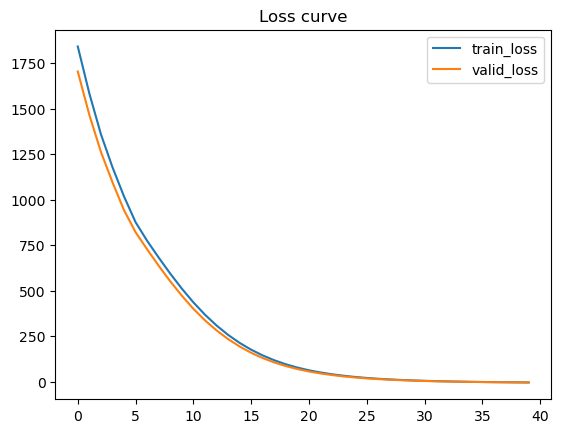

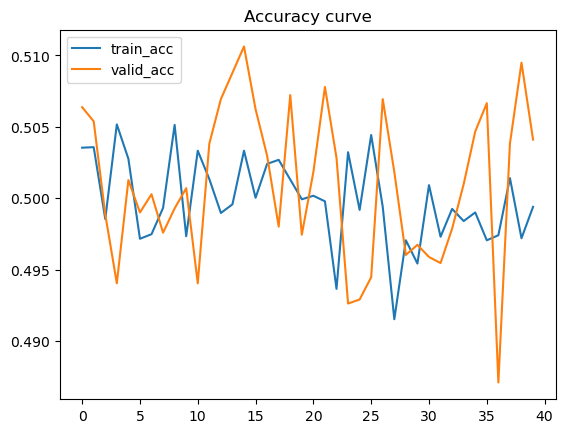

In [18]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [19]:
batch_size=20
test_df = pd.read_pickle('test.pkl').reset_index(drop=True)
        
class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)
      
N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)

    
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [20]:
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()
            with torch.no_grad():
                lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static, model)
                total += y.shape[0]
                correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
                y_true.append(y.reshape(-1))
                y_pred.append(pred_label.reshape(-1))

print(f"the test accuracy is {correct/total}")

/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


the test accuracy is 0.5176864244741873


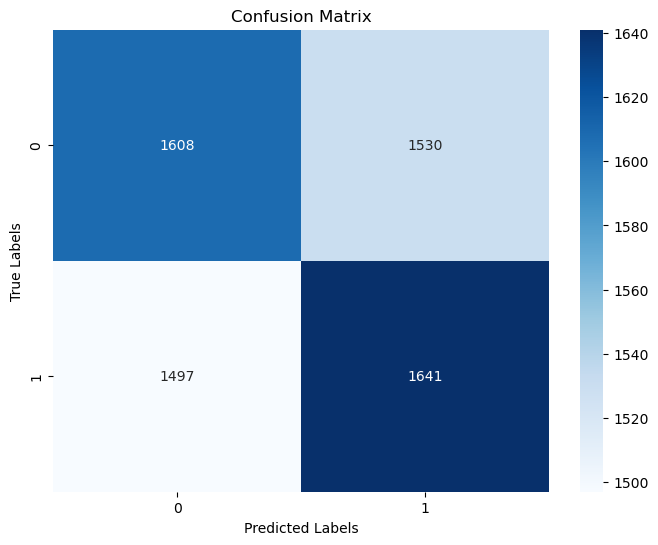

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()